# 0 - Import pakietów

In [1]:
import string
import tabulate
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

from joblib import Parallel, delayed
from pandas import read_csv
from tqdm import tqdm

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import contractions
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from webencodings import labels

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

C:\Users\bordo\anaconda3\envs\nlp_hf_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

---
# 1 - Pobranie danych

### 1.1 - Wczytanie pierwotnych danych

Dane umieszczone w lokalnych folderach projektu, a dokładniej w folderze `dane`.

In [2]:
train_df = pd.read_csv('data/train.csv', header=None, names=['opinion', 'title', 'content'])

In [3]:
test_df = pd.read_csv('data/test.csv', header=None, names=['opinion', 'title', 'content'])

Wyświetlenie pierwszych wierszy obu zbiorów danych:

In [4]:
train_df.head()

,opinion,title,content
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [5]:
test_df.head()

,opinion,title,content
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   opinion  int64 
 1   title    object
 2   content  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   opinion  400000 non-null  int64 
 1   title    399976 non-null  object
 2   content  400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


Stworzenie listy zawierającej odniesienie do zbioru treningowego i testowego do działania na całości.

In [8]:
full_df = [train_df, test_df]

---
# 2 - Czyszczenie danych

Sprawdzenie, czy dane zwierają puste atrybyuty:

In [9]:
nan_sum = 0
for df in full_df:
    nan_sum += df.isna().sum()

print(nan_sum)

opinion      0
title      231
content      0
dtype: int64


Występują puste atrybuty w kolumnie *title*. W celu obsłużenia pustych danych, pozbywam się wszystkich kolumn, które takie dane zawierają oraz wyświetlam wynik:

In [10]:
for df in full_df:
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

nan_sum = 0
for df in full_df:
    nan_sum += df.isna().sum()

print(nan_sum)

opinion    0
title      0
content    0
dtype: int64


---
# 3 - Przetwarzanie wstępne

### 3.1 - Przetworzenie tekstu do odpowiednich jednostek słownych

In [11]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
punctuation.update(["``", "''", "“", "”", "‘", "’", "«", "»", "„", "`", "´", "′", "″"])
punctuation_str = ''.join([p for p in punctuation if len(p) == 1])

Funkcja mająca na celu przetworzenie danych tekstowych, aby podzielić zbiory wyrazów na pojedyncze jednostki słowne do dalszej analizy. Co się wykonuje:
- rozwinięcie kontrakcji na pełne wyrażenia;
- zamiana wszystkich liter na małe;
- tokenizacja;
- usuwanie znaków interpunkcyjnych;
- usuwanie słów mało znaczącaych w analizie takich jak spójniki i inne (zbiór *stopwords* w bibliotece NLTK);
- lematyzacja;
- stemming;

Gdzie na wyjście podawany jest do wyboru efekt tokenizacji, stemmingu lub lematyzacji.

In [12]:
def preprocess_text(text,
                    use_tokenization=False,
                    use_stemming=False,
                    use_lemmatization=False):
    """
    Parametry:
        - text                  : string, tekst do przetwarzania
        - use_stemming          : czy stosować stemming
        - use_lemmatization     : czy stosować lematyzację
        - use_tokenization      : czy zapisać efekt tokenizacji

    Wyjście:
        Słownik na wzór:
        {"stemmed": "very nice", "lemmatized": "very nice"}
    """

    # Rozwijnie kontrakcji ("I've -> I have" itp.)
    text = contractions.fix(text)

    # Zamiana na małe litery
    text = text.lower()

    # Tokenizacja
    tokens = word_tokenize(text)

    # Usunięcie znaków interpunkcyjnych
    filtered_tokens = [t.translate(str.maketrans('', '', punctuation_str)) for t in tokens]

    # Usunięcie stopwords (zbiór słów "pomijalnych" z NLTK)
    filtered_stopwords_tokens = []
    for t in filtered_tokens:
        if t in stop_words:
            continue
        filtered_stopwords_tokens.append(t)

    filtered_tokens = filtered_stopwords_tokens

    # Opcjonalny zapis do ramki wyjściowej efektów tokenizacji (samej), stemmingu lub lematyzacji
    output = {}
    if use_tokenization:
        output["tokenized"] = " ".join(tokens)

    if use_stemming:
        stemmed = [stemmer.stem(t) for t in filtered_tokens]
        output["stemmed"] = " ".join(stemmed)

    if use_lemmatization:
        lemmatized = [lemmatizer.lemmatize(t) for t in filtered_tokens]
        output["lemmatized"] = " ".join(lemmatized)

    return output

In [13]:
def batch_preprocess_columns(
    df_og,
    columns_to_preprocess,  # np. ["title", "content"]
    suffixes={"tokenized": "_tokenized", "stemmed": "_stemmed", "lemmatized": "_lemmatized"},    # jaki dopisek do nazwy kolumny
    use_tokenization=False,
    use_stemming=False,
    use_lemmatization=False,
    output_path="processed_text.txt",
    n_jobs=-1,
    verbose=10
):
    """
    Przetwarza (równolegle) wskazane kolumny DataFrame, wywołując `preprocess_text`
    dla każdego wiersza w kolumnie.
    - df                    : wejściowy DataFrame
    - columns_to_preprocess : lista nazw kolumn do przetwarzania (np. ["title", "content"])
    - suffixes              : string, np. "_processed", "_stemmed", itp. Zostanie dodany do nazwy.
    - use_tokenization, use_stemming, use_lemmatization:
        parametry przekazywane do `preprocess_text`
    - n_jobs                : ile równoległych zadań (jobów). -1 = użyj wszystkich rdzeni
    - verbose               : poziom szczegółowości logów joblib / tqdm

    Zwraca nowy DataFrame z dodatkowymi kolumnami <nazwa_kolumny> + <suffix>.
    """

    df = df_og.copy()
    result = pd.DataFrame()

    for col in columns_to_preprocess:
        texts = df[col].astype(str).tolist()

        # Przetwarzanie równoległe
        processed = Parallel(n_jobs=n_jobs, verbose=verbose)(
            delayed(preprocess_text)(
                text,
                use_stemming=use_stemming,
                use_lemmatization=use_lemmatization,
                use_tokenization=use_tokenization
            )
            for text in tqdm(texts, desc=f"Przetwarzanie kolumny {col}")
        )

        if use_tokenization:
            result[col + suffixes["tokenized"]] = [r.get("tokenized", "") for r in processed]

        if use_stemming:
            result[col + suffixes["stemmed"]] = [r.get("stemmed", "") for r in processed]

        if use_lemmatization:
            result[col + suffixes["lemmatized"]] = [r.get("lemmatized", "") for r in processed]

    return result

In [14]:
def process_or_read(train_file, test_file, train_df, test_df):
    if os.path.isfile(train_file):
        proc_train = read_csv(train_file, header=0)
    else:
        proc_train = batch_preprocess_columns(
            train_df,
            columns_to_preprocess=["title", "content"],
            use_tokenization=False,
            use_stemming=True,
            use_lemmatization=True,
            output_path=train_file,
            verbose=0)

    if os.path.isfile(test_file):
        proc_test = read_csv(test_file, header=0)
    else:
        proc_test = batch_preprocess_columns(
            test_df,
            columns_to_preprocess=["title", "content"],
            use_tokenization=False,
            use_stemming=True,
            use_lemmatization=True,
            output_path=test_file,
        )

    train_df = pd.concat([train_df, proc_train], axis=1)
    test_df = pd.concat([test_df, proc_test], axis=1)
    train_df['full_lematized'] = train_df['title_lemmatized'] + " " + train_df['content_lemmatized']
    test_df['full_lematized'] = test_df['title_lemmatized'] + " " + test_df['content_lemmatized']
    full_df = (train_df, test_df)
    return full_df

In [15]:
train_file = "train_opinions_processed_lemmatized.csv"
test_file = "test_opinions_processed_lemmatized.csv"

In [16]:
proc_train_df, proc_test_df = process_or_read(train_file, test_file, train_df, test_df)

In [17]:
proc_train_df.head()

,opinion,title,content,title_lemmatized,content_lemmatized,full_lematized
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even nongamer,sound track beautiful paint senery mind well ...,stuning even nongamer sound track beautiful p...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,best soundtrack ever anything,reading lot review saying best game soundtrack...,best soundtrack ever anything reading lot rev...
2,2,Amazing!,This soundtrack is my favorite music of all ti...,amazing,soundtrack favorite music time hand intense ...,amazing soundtrack favorite music time hand ...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack,truly like soundtrack enjoy video game music ...,excellent soundtrack truly like soundtrack enj...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull jaw floor hearing,played game know divine music every single s...,remember pull jaw floor hearing played game ...


In [18]:
proc_test_df.head()

,opinion,title,content,title_lemmatized,content_lemmatized,full_lematized
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,great cd,lovely pat one great voice generation listene...,great cd lovely pat one great voice generation...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,one best game music soundtrack game really play,despite fact played small portion game music ...,one best game music soundtrack game really pl...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,battery died within year,bought charger jul 2003 worked ok design nice...,battery died within year bought charger jul 2...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,work fine maha energy better,check maha energy website powerex mhc204f cha...,work fine maha energy better check maha energ...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,great nonaudiophile,reviewed quite bit combo player hesitant due u...,great nonaudiophile reviewed quite bit combo p...


### 3.2 - Ponowne sprawdzenie wartości pustych

In [19]:
print(proc_train_df.isna().sum())

opinion                   0
title                     0
content                   0
title_lemmatized      13055
content_lemmatized        1
full_lematized        13056
dtype: int64


Okazuję się, że po wstępnym przetworzeniu danych znajdują się komórki, w których usunięto całą zawartość. Jest to niewielki udział w stosunku do danych całościowych, ~13.000 do niemal 3.6 mln w zbiorze treningowym.

In [20]:
proc_train_df.dropna(inplace=True)
proc_test_df.dropna(inplace=True)
proc_train_df.reset_index(drop=True, inplace=True)
proc_test_df.reset_index(drop=True, inplace=True)

In [21]:
print(proc_train_df.isna().sum())
print(proc_test_df.isna().sum())

opinion               0
title                 0
content               0
title_lemmatized      0
content_lemmatized    0
full_lematized        0
dtype: int64
opinion               0
title                 0
content               0
title_lemmatized      0
content_lemmatized    0
full_lematized        0
dtype: int64


### 3.3 - Zapis do pliku

In [22]:
columns_to_save = ["title_lemmatized", "content_lemmatized"]

In [23]:
if not os.path.isfile(train_file):
    proc_train_df.to_csv(train_file, index=False, encoding="utf-8", columns=columns_to_save)
if not os.path.isfile(test_file):
    proc_test_df.to_csv(train_file, index=False, encoding="utf-8", columns=columns_to_save)

---
# 4 - Analiza eksploracyjna

In [29]:
positive_reviews = proc_train_df[proc_train_df['opinion'] == 2]['full_lematized']
negative_reviews = proc_train_df[proc_train_df['opinion'] == 1]['full_lematized']

positive_words_list = [word for review in positive_reviews for word in review.split()]
negative_words_list = [word for review in negative_reviews for word in review.split()]

### 4.1 - Analiza pojedynczych słów

Procentowy udział opinii pozytywnych i negatywnych

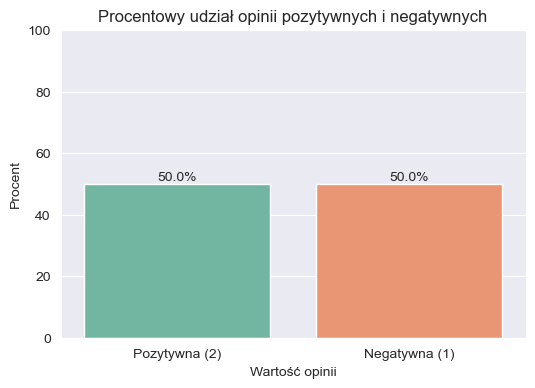

In [143]:
opinion_counts = train_df['opinion'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=opinion_counts.index, y=opinion_counts.values, palette='Set2', hue=opinion_counts.index, legend=False)

for i, percentage in enumerate(opinion_counts.values):
    ax.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=10)

plt.title('Procentowy udział opinii pozytywnych i negatywnych')
plt.xlabel('Wartość opinii')
plt.ylabel('Procent')
plt.xticks(ticks=[0, 1], labels=['Pozytywna (2)', 'Negatywna (1)'])
plt.ylim(0, 100)
plt.show()

Wykresy pokazujące ilość wystąpień poszczególnych słów w opiniach. Wykresy przedstawiają wystąpienia słów jedynie po tokenizacji oraz po pełnym przetwrzaniu z podziałem na sentyment.

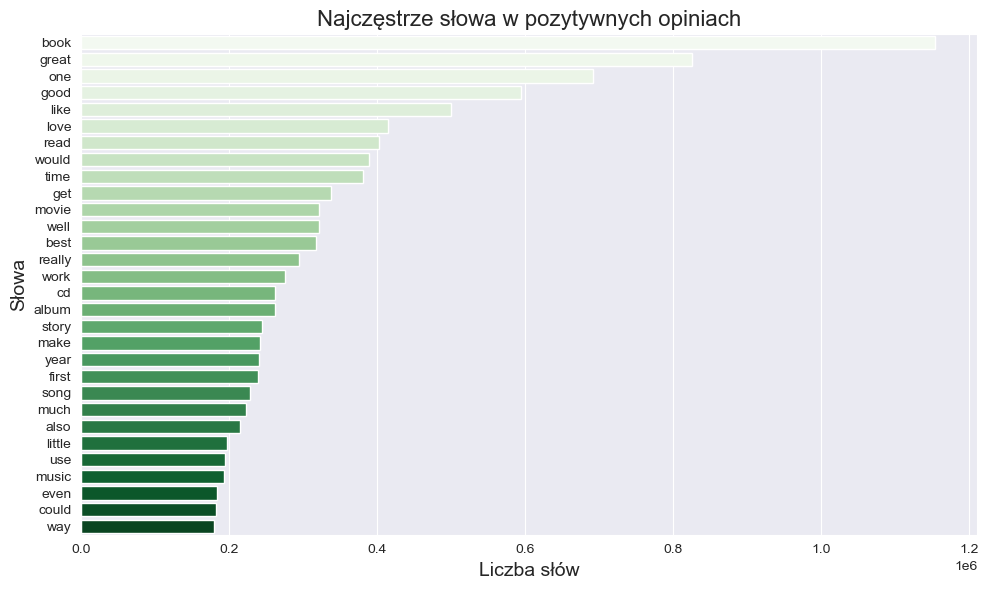

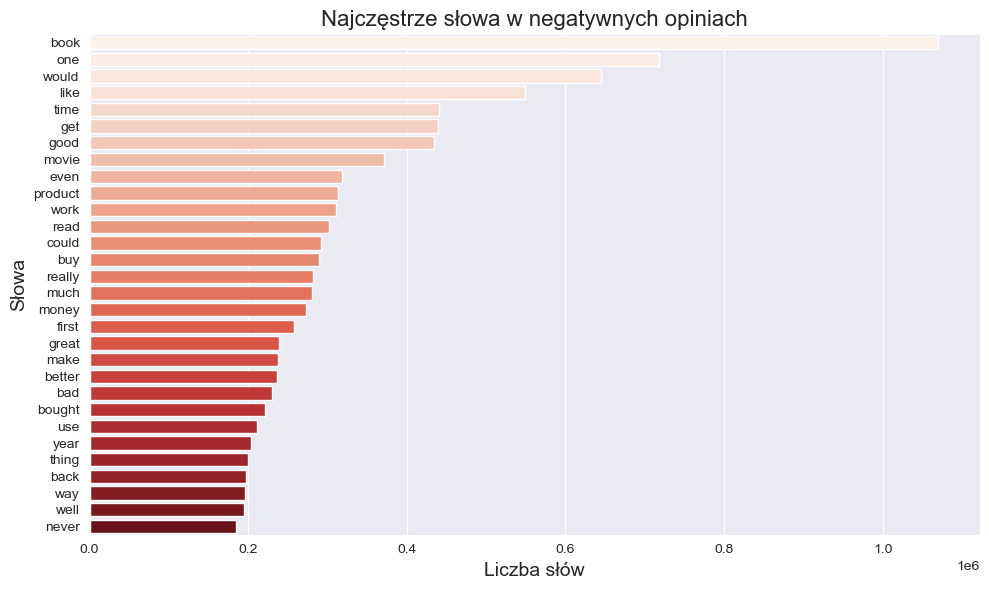

In [226]:
# Najczęstsze słowa dla pozytywnych i negatywnych recenzji

positive_words_counter = Counter(positive_words_list).most_common(30)
negative_words_counter = Counter(negative_words_list).most_common(30)

def plot_most_common_words(common_words, sentiment, color):
    words, counts = zip(*common_words)  # Rozpakowanie słów i ich zliczeń
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette=color, hue=list(words), legend=False)
    plt.title(f'Najczęstrze słowa w {sentiment} opiniach', fontsize=16)
    plt.xlabel('Liczba słów', fontsize=14)
    plt.ylabel('Słowa', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_most_common_words(positive_words_counter, 'pozytywnych', 'Greens')
plot_most_common_words(negative_words_counter, 'negatywnych', 'Reds')

### 4.2 - Analiza *n*-gramów

In [159]:
def get_ngrams(corpus, ngram_range=(2,2)):
    vec = CountVectorizer(
    ngram_range=ngram_range,
    min_df=5,
    max_features=1000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq

In [214]:
def plot_ngrams(ngrams, sentiment, color, ngram='n', n=30):
    ngrams = ngrams[:n]
    combinations_, counts = zip(*ngrams)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=combinations_, palette=color, hue=counts, legend=False)
    plt.title(f'Najczęstrze {ngram}-gramy w {sentiment} opiniach', fontsize=16)
    plt.xlabel('Częstotliwość', fontsize=14)
    plt.ylabel(f'{ngram}-gramy', fontsize=14)
    plt.tight_layout()
    plt.show()

In [215]:
two_grams_positive = get_ngrams(positive_reviews, ngram_range=(2,2))

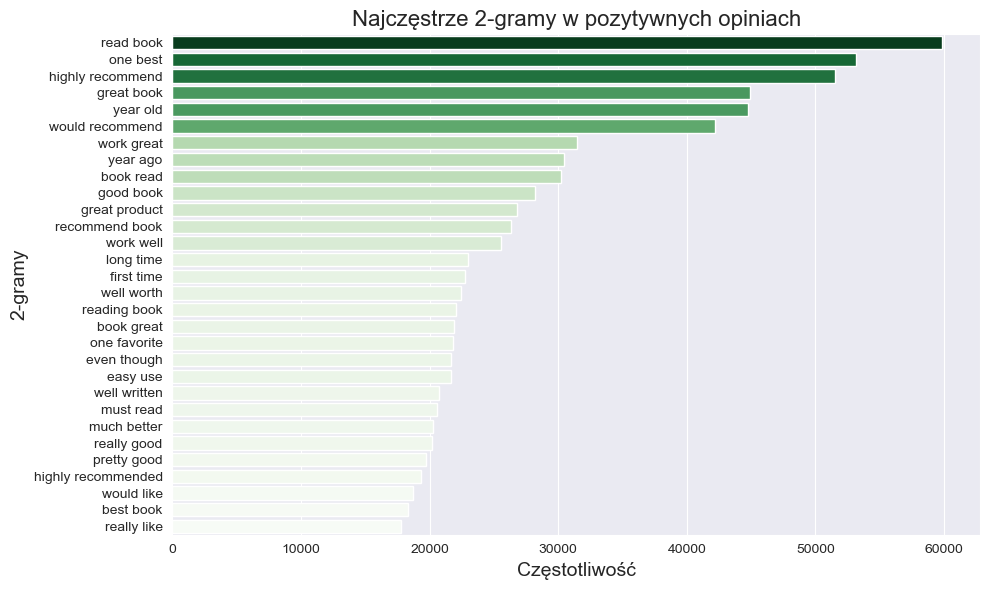

In [216]:
plot_ngrams(two_grams_positive, 'pozytywnych', 'Greens', ngram='2')

In [219]:
two_grams_negative = get_ngrams(negative_reviews, ngram_range=(2,2))

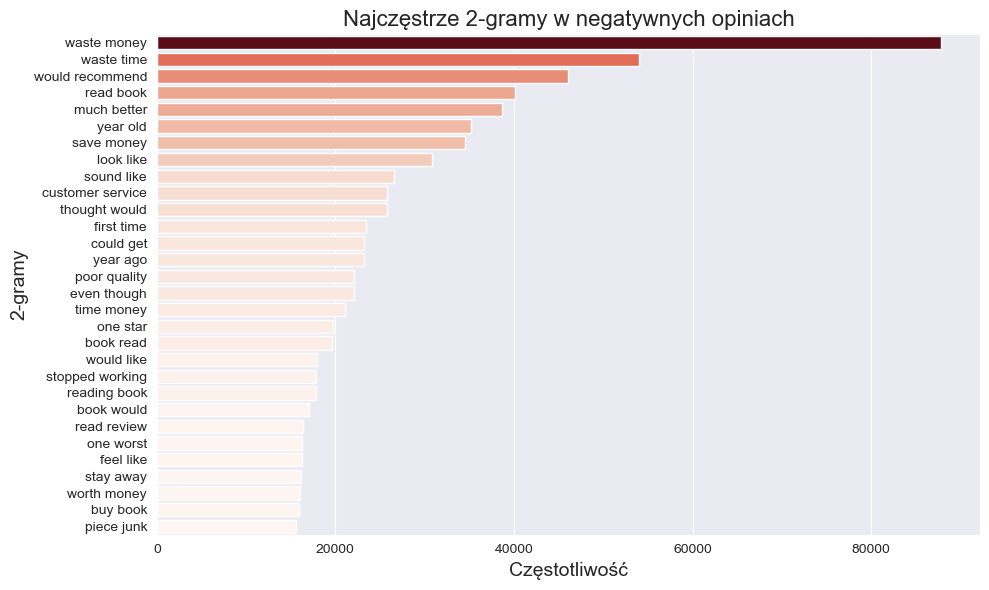

In [220]:
plot_ngrams(two_grams_negative, 'negatywnych', 'Reds', ngram='2')

In [221]:
three_grams_positive = get_ngrams(positive_reviews, ngram_range=(3,3))

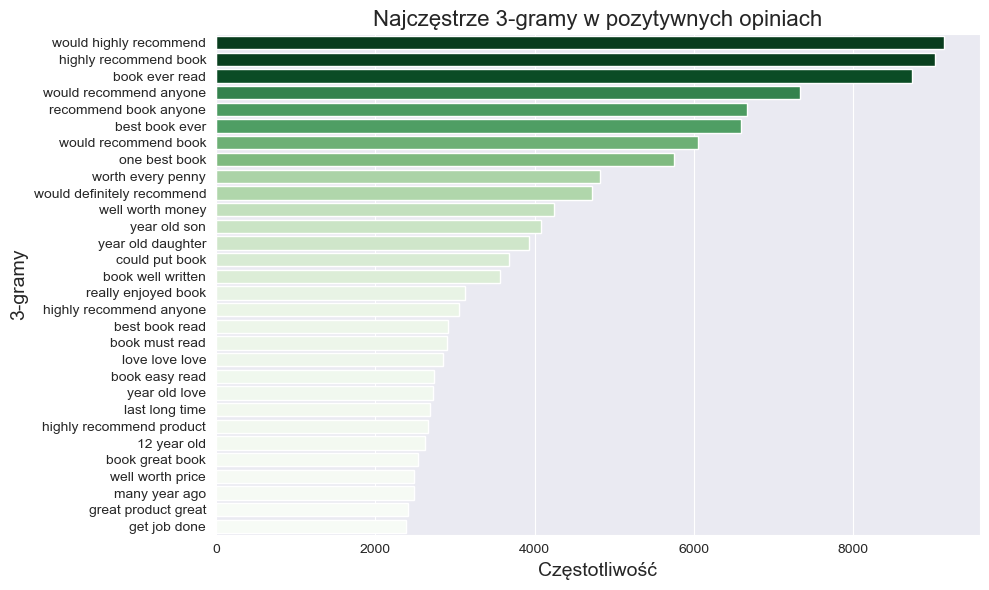

In [222]:
plot_ngrams(three_grams_positive, 'pozytywnych', 'Greens', ngram='3')

In [223]:
three_grams_negative = get_ngrams(negative_reviews, ngram_range=(3,3))

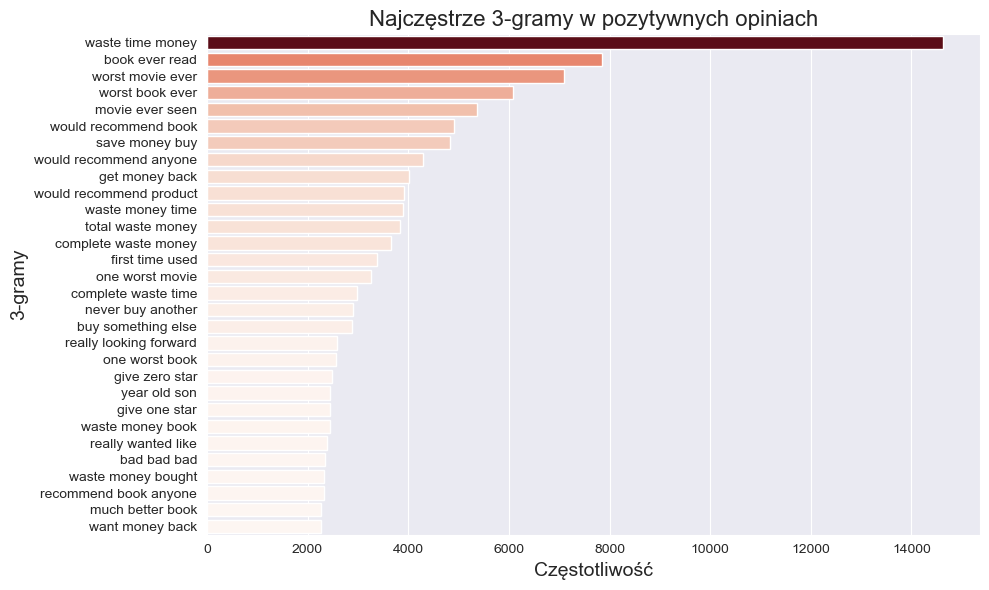

In [224]:
plot_ngrams(three_grams_negative, 'negatywnych', 'Reds', ngram='3')

---
# 5 - TF-IDF

Wybranie optymalnych parametrów dla *TF-IDF*.

Wybranie 10% zbioru danych treninigowych do wybrania parametrów *TF-IDF*

In [59]:
X_sample, X_rest, y_sample, y_rest = train_test_split(
    proc_train_df['full_lematized'],
    proc_train_df['opinion'],
    train_size=0.1,
    random_state=42,
    stratify=proc_train_df['opinion']  # klucz do uzyskania reprezentatywnej próbki
)

Sprawdzenie skuteczności różnych wartości parametrów *TF-IDF* przy użyciu prostego klasyfikatora regresji logistycznej.

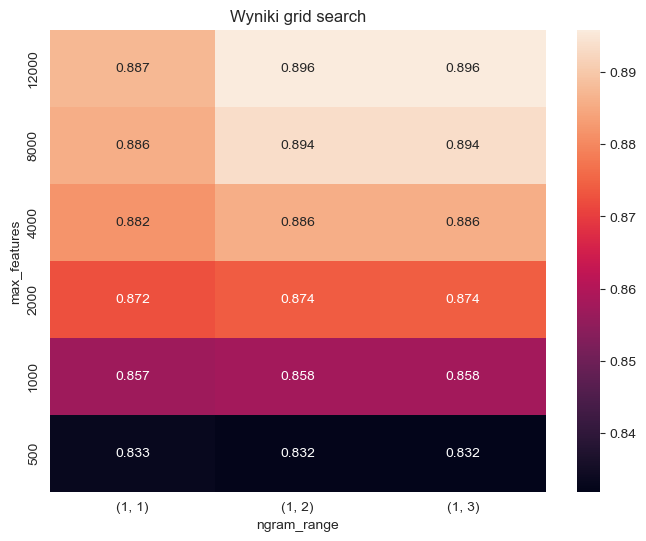

In [26]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=200))
])

param_grid = {
    'tfidf__max_features': [500, 1_000, 2_000, 4_000, 8_000, 12_000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_sample, y_sample)

results = pd.DataFrame(grid.cv_results_)

# Tabela przestawna
pivot_table = results.pivot(
    index='param_tfidf__max_features',
    columns='param_tfidf__ngram_range',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f"
)

plt.xlabel("ngram_range")
plt.ylabel("max_features")
plt.title("Wyniki grid search")
plt.gca().invert_yaxis()
plt.show()

In [24]:
best_tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2)
)

# 6 - Klasyfikatory pakietu sci-kit-learn

Przypisanie nowych nazw na elementy zbioru treningowego i testowego.

In [25]:
X_train, X_test, y_train, y_test = proc_train_df['full_lematized'], proc_test_df['full_lematized'], proc_train_df['opinion'], proc_test_df['opinion']

Utworzenie gotowych macierzy *tf-idf*, aby przyspieszyć proces badania klasyfikatorów. Parametry wektoryzatora *tf-idf* zostały wybrane w sekcji piątej.

In [26]:
X_train_tfidf = best_tfidf.fit_transform(X_train)

In [27]:
X_test_tfidf = best_tfidf.transform(X_test)

## 6.1 - Funkcje do przetwarzania klasyfikatorów sci-kit-learn

Funkcja zajmująca się wyłacznie wyborem najlepszych parametrów wybranego klasyfikatora.

In [28]:
def find_best_params(model, X_sample, y_sample, param_grid, tfidf_vectorizer, cv=3, n_jobs=-1, tolerance=0.005, n=3):

    pipeline = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv,   # cross-validation
        scoring='accuracy',
        n_jobs=n_jobs
    )

    grid.fit(X_sample, y_sample)
    results_df = pd.DataFrame(grid.cv_results_)

    param_names = list(param_grid.keys())
    param_cols  = [f'param_{p}' for p in param_names]
    label_cols = [param.split('__')[-1] for param in param_names]

    plot_cv_results_heatmap(
        cv_results_df = results_df,
        param_x       = param_cols[0],   # 'param_clf__C'
        param_y       = param_cols[1],   # 'param_clf__penalty'
        score_col     = 'mean_test_score',
        xlabel        = label_cols[0], # 'C'
        ylabel        = label_cols[1], # 'penalty'
        invert_yaxis=True,
        cmap='Blues'
    )

    # Wyniki
    print("Bezwględnie najlepsze parametry:", grid.best_params_)
    print("Bezwględnie najlepszy wynik CV:", grid.best_score_)

    best = results_df['mean_test_score'].max()

    candidates = results_df[
        results_df['mean_test_score'] <= best - tolerance
        ].sort_values('rank_test_score')

    print()
    print(f'Top {n} po uwzględnieniu tolerancji')
    print(candidates[['params', 'mean_test_score', 'rank_test_score']].iloc[:3])

    temp_best = candidates['params'].iloc[0]
    result_best_params = {}
    for key in temp_best.keys():
        if key.startswith('clf__'):
            result_best_params[key.split('__')[-1]] = temp_best[key]

    return result_best_params, results_df

Funkcja zajmująca się ewaluacją wybranego klasyfikatora oraz przedstawieniem wyników w formie graficznej i tekstowej. Tworzona jest macierz pomyłek oraz wypisywane jest *classification_report*.

In [29]:
def evaluate_model(model, X_test, y_test, labels=None):

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    report = classification_report(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm,
        annot=True,
        fmt="d",
        cbar=False,
        xticklabels=labels,
        yticklabels=labels)
    plt.title("Macierz pomyłek")
    plt.xlabel("Przewidziane wartości")
    plt.ylabel("Wartości prawdziwe")
    plt.show()

    print("Classification Report:")
    print(report)

    return cm, report

In [30]:
def plot_cv_results_heatmap(
    cv_results_df,
    param_x,
    param_y,
    score_col='mean_test_score',
    xlabel='Param X',
    ylabel='Param Y',
    title='Wyniki grid search',
    invert_yaxis=False,
    cmap='viridis'
    ):

    pivot_table = cv_results_df.pivot(
        index=param_y,
        columns=param_x,
        values=score_col
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap=cmap)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if invert_yaxis:
        plt.gca().invert_yaxis()

    plt.show()

In [31]:
def save_classification_results(
    report: str,
    confusion_matrix_data: any, # Zwykle numpy.ndarray lub lista list
    output_dir: str,
    labels: list[str] = None,
    file_prefix: str = 'test'
    ) -> None:
    """
    Zapisuje raport klasyfikacji i dane macierzy pomyłek do plików.

    Args:
        report (str): Raport klasyfikacji wygenerowany np. przez
                      sklearn.metrics.classification_report.
        confusion_matrix_data (Any): Dane macierzy pomyłek (np. z
                                     sklearn.metrics.confusion_matrix).
        labels (list[str]): Lista etykiet dla wierszy i kolumn macierzy pomyłek.
        output_dir (str): Katalog, w którym zostaną zapisane pliki.
        file_prefix (str, optional): Prefiks dodawany do nazw zapisywanych plików.
                                     Domyślnie 'test'.
    """

    # Sprawdzenie, czy katalog docelowy istnieje
    try:
        os.path.isdir(output_dir)
    except OSError as e:
        print(f"Katalog {output_dir} nie istnieje! : {e}")
        return # Przerwij, jeśli nie można utworzyć katalogu

    # --- Zapis raportu klasyfikacji ---
    report_path = os.path.join(output_dir, f"{file_prefix}_classification_report.txt")
    try:
        with open(report_path, 'w', encoding='utf-8') as file:
            file.write(report)
        print(f"Raport klasyfikacji na zbiorze <{file_prefix}> zapisany w: {report_path}")
    except IOError as e:
        print(f"Błąd podczas zapisu raportu klasyfikacji na zbiorze <{file_prefix}> do {report_path}! : {e}")

    # --- Zapis macierzy pomyłek ---
    cm_path = os.path.join(output_dir, f"{file_prefix}_confusion_matrix.csv")
    try:
        cm_df = pd.DataFrame(confusion_matrix_data, index=labels, columns=labels)
        cm_df.to_csv(cm_path)
        print(f"Dane macierzy pomyłek zbioru <{file_prefix}> zapisane w: {cm_path}")
    except (IOError, pd.errors.EmptyDataError) as e:
        print(f"Błąd podczas zapisu danych macierzy zbioru <{file_prefix}> do {cm_path}! : {e}")

Główna funkcja do testowania róznych parametrów wybranego klasyfikatora oraz jego ewaluacji na zbiorze treningowym lub testowym.

In [32]:
def tune_and_evaluate_model(
    model,
    X_train, y_train,
    X_test,  y_test,
    param_grid,
    tfidf_vectorizer=None,
    tfidf_train_matrix=None,
    tfidf_test_matrix=None,
    tune_split_percentage=0.1,
    cv=3,
    n_jobs=-1,
    tolerance=0.002,
    n=3,
    evaluate_train=False,
    evaluate_test=True,
    return_best_params_only=False,
    save_tuning=True,
    save_evaluation=True,
    output_dir="classifiers_results"
):
    # Walidacja podania tfidf_train_matrix i tfidf_test_matrix
    if (tfidf_train_matrix is None) ^ (tfidf_test_matrix is None):
        raise ValueError(
            "Jeśli podano macierz tfidf, to należy podać zarówno `tfidf_train_matrix`, jak i `tfidf_test_matrix`."
        )

    # Jeżeli nie ma macierzy tf-idf, budowane są z X_train/X_test
    if tfidf_train_matrix is None:
        tfidf_train_matrix = tfidf_vectorizer.fit_transform(X_train)
        tfidf_test_matrix  = tfidf_vectorizer.transform(X_test)

    # Mniejsze próbki do dostrajania parametrów
    X_sample, _, y_sample, _ = train_test_split(
        X_train, y_train,
        train_size=tune_split_percentage,
        random_state=42,
        stratify=y_train
    )

    # Dostrajanie parametrów
    best_params, tune_df = find_best_params(
        model=model,
        X_sample=X_sample, y_sample=y_sample,
        param_grid=param_grid,
        tfidf_vectorizer=tfidf_vectorizer,
        cv=cv,
        n_jobs=n_jobs,
        tolerance=tolerance,
        n=n
    )

    # Wyciągnięcie nazw konkretnych badanych parametrów
    param_names = list(param_grid.keys())
    label_cols = [param.split('__')[-1] for param in param_names]

    # Ścieżka do zapisu plików
    output_dir = os.path.join(output_dir, model.__class__.__name__, "-".join(label_cols))

    if save_tuning or save_evaluation:
        try:
            os.makedirs(output_dir, exist_ok=True)
        except OSError as e:
            print(f"Nie można utworzyć katalogu {output_dir}! : {e}")

    if save_tuning:
        try:
            tune_df.to_csv(os.path.join(output_dir, "tuning_results.csv"), index=False)
        except OSError as e:
            print(f"Nie można zapisać pliku wynikowego tuning_results.csv do {output_dir}! : {e}")

    # Zwrócenie samych parametrów
    if return_best_params_only:
        return best_params

    # Ustawienie najlepszych parametrów i fitowanie na całym zbiorze treningowym
    model = model.set_params(**best_params)
    model.fit(tfidf_train_matrix, y_train)
    labels = model.classes_

    # Ewaluacja na zbiorze treningowym lub testowym
    if evaluate_train:
        print("\n=== Ewaluacja na zbiorze treningowym ===")
        confusion_matrix, report = evaluate_model(model, tfidf_train_matrix, y_train, labels=labels)

        # Zapis wyników ewaluacji na zbiorze treningowym
        if save_evaluation:
            save_classification_results(report=report, confusion_matrix_data=confusion_matrix, output_dir=output_dir, labels=labels, file_prefix="train")

    if evaluate_test:
        print("\n=== Ewaluacja na zbiorze testowym ===")
        confusion_matrix, report = evaluate_model(model, tfidf_test_matrix, y_test, labels=labels)

        # Zapis wyników ewaluacji na zbiorze testowym
        if save_evaluation:
            save_classification_results(report=report, confusion_matrix_data=confusion_matrix, output_dir=output_dir, labels=labels, file_prefix="test")

    return model, best_params

## 6.2 - Badanie klasyfikatorów

### 6.2.a - Regresja liniowa

In [41]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train_tfidf, [y+1 for y in y_train])
evaluate_model(clf, X_test_tfidf, [y+1 for y in y_test], labels=[1,2])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### 6.2.1 - Regresja logistyczna

C:\Users\bordo\anaconda3\envs\nlp_hf_env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


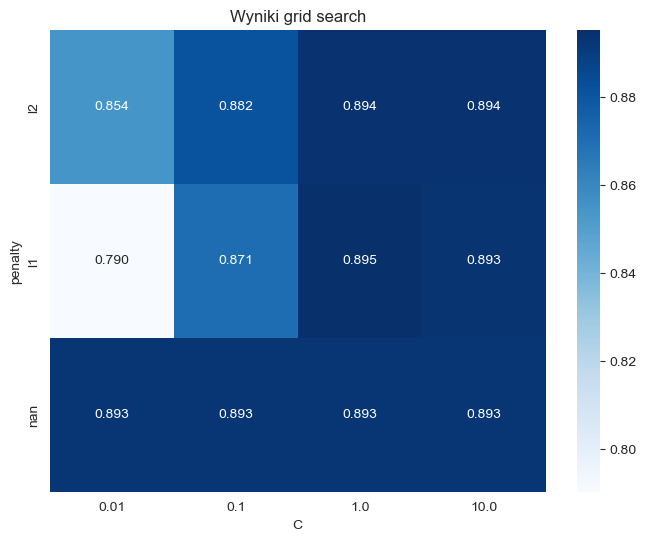

Bezwględnie najlepsze parametry: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Bezwględnie najlepszy wynik CV: 0.8951663500299197

Top 3 po uwzględnieniu tolerancji
                                               params  mean_test_score  \
6   {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__so...         0.895166   
7   {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so...         0.893912   
10  {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__s...         0.893870   

    rank_test_score  
6                 1  
7                 2  
10                3  

=== Ewaluacja na zbiorze testowym ===


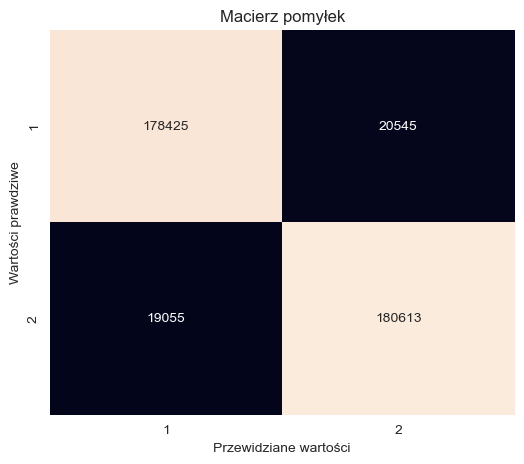

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.90      0.90    198970
           2       0.90      0.90      0.90    199668

    accuracy                           0.90    398638
   macro avg       0.90      0.90      0.90    398638
weighted avg       0.90      0.90      0.90    398638

Raport klasyfikacji na zbiorze <test> zapisany w: classifiers_results\LogisticRegression\C-penalty-solver\test_classification_report.txt
Dane macierzy pomyłek zbioru <test> zapisane w: classifiers_results\LogisticRegression\C-penalty-solver\test_confusion_matrix.csv


(LogisticRegression(n_jobs=-1, penalty='l1', solver='saga'),
 {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'})

In [35]:
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2', None],
    'clf__solver': ['saga']
}
tune_and_evaluate_model(LogisticRegression(n_jobs=-1), X_train, y_train, X_test, y_test, param_grid, best_tfidf, tfidf_train_matrix=X_train_tfidf, tfidf_test_matrix=X_test_tfidf, tolerance=0)

### 6.2.2 - Drzewo decyzyjne

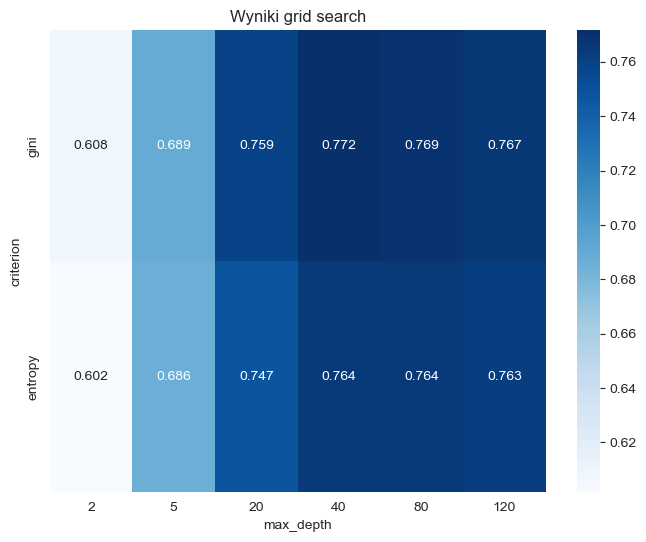

Bezwględnie najlepsze parametry: {'clf__criterion': 'gini', 'clf__max_depth': 40}
Bezwględnie najlepszy wynik CV: 0.7716527300483804

Top 3 po uwzględnieniu tolerancji
                                               params  mean_test_score  \
4    {'clf__criterion': 'gini', 'clf__max_depth': 80}         0.769297   
5   {'clf__criterion': 'gini', 'clf__max_depth': 120}         0.766941   
10  {'clf__criterion': 'entropy', 'clf__max_depth'...         0.764490   

    rank_test_score  
4                 2  
5                 3  
10                4  


In [ ]:
param_grid_dt = {
    'clf__max_depth': [2, 5, 20, 40, 80, 120],
    'clf__criterion': ['gini', 'entropy']
}
tune_and_evaluate_model(DecisionTreeClassifier(random_state=42), X_train, y_train, X_test, y_test, param_grid_dt, best_tfidf, tfidf_train_matrix=X_train_tfidf, tfidf_test_matrix=X_test_tfidf)

### 6.2.3 - Las losowy

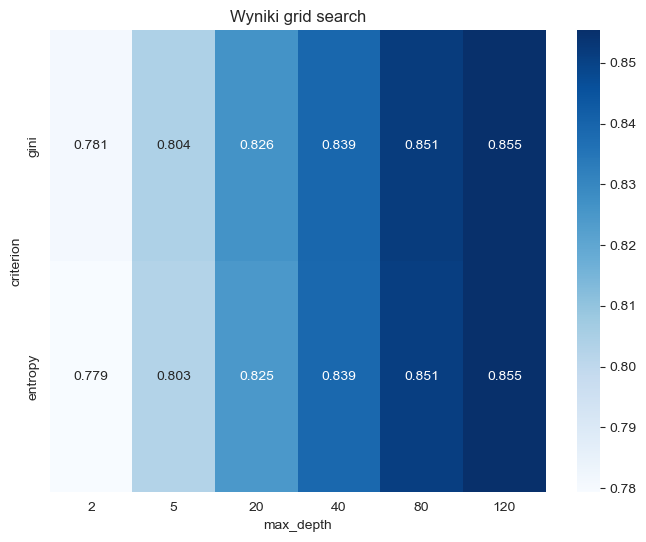

Bezwględnie najlepsze parametry: {'clf__criterion': 'entropy', 'clf__max_depth': 120}
Bezwględnie najlepszy wynik CV: 0.8553334121730561

Top 3 po uwzględnieniu tolerancji
                                              params  mean_test_score  \
3   {'clf__criterion': 'gini', 'clf__max_depth': 40}         0.839263   
9  {'clf__criterion': 'entropy', 'clf__max_depth'...         0.838934   
2   {'clf__criterion': 'gini', 'clf__max_depth': 20}         0.826488   

   rank_test_score  
3                5  
9                6  
2                7  

=== Ewaluacja na zbiorze testowym ===


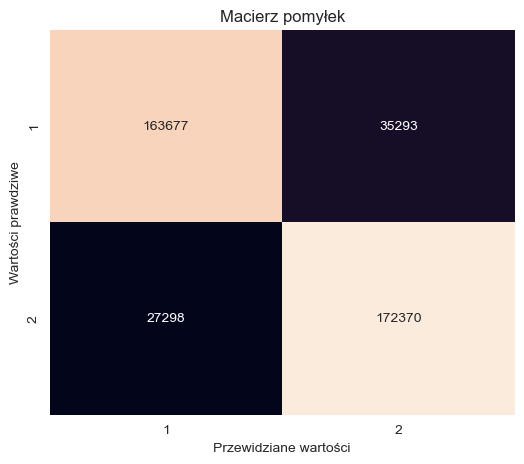

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.82      0.84    198970
           2       0.83      0.86      0.85    199668

    accuracy                           0.84    398638
   macro avg       0.84      0.84      0.84    398638
weighted avg       0.84      0.84      0.84    398638

Raport klasyfikacji na zbiorze testowym zapisany w: max_depth_criterion
Dane macierzy pomyłek zapisane w: max_depth_criterion


(RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42),
 {'criterion': 'gini', 'max_depth': 40})

In [44]:
param_grid_rf = {
    'clf__max_depth': [2, 5, 20, 40, 80, 120],
    'clf__criterion': ['gini', 'entropy']
}
tune_and_evaluate_model(RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_test, y_test, param_grid_rf, best_tfidf, tfidf_train_matrix=X_train_tfidf, tfidf_test_matrix=X_test_tfidf)

## 6.? - TEST

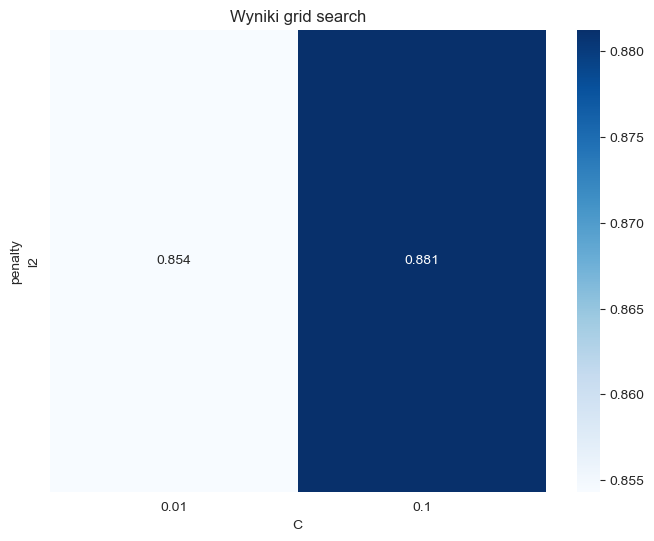

Bezwględnie najlepsze parametry: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Bezwględnie najlepszy wynik CV: 0.8812567446707794

Top 3 po uwzględnieniu tolerancji
                                   params  mean_test_score  rank_test_score
0  {'clf__C': 0.01, 'clf__penalty': 'l2'}         0.854319                2

=== Ewaluacja na zbiorze testowym ===


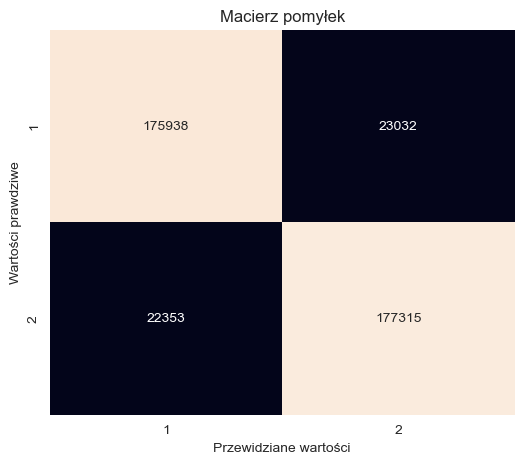

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.88      0.89    198970
           2       0.89      0.89      0.89    199668

    accuracy                           0.89    398638
   macro avg       0.89      0.89      0.89    398638
weighted avg       0.89      0.89      0.89    398638

Raport klasyfikacji na zbiorze testowym zapisany w: C_penalty
Dane macierzy pomyłek zapisane w: C_penalty


(LogisticRegression(C=0.01), {'C': 0.01, 'penalty': 'l2'})

In [40]:
param_grid = {
    'clf__C': [0.01, 0.1],
    'clf__penalty': ['l2']
}
tune_and_evaluate_model(LogisticRegression(), X_train, y_train, X_test, y_test, param_grid, best_tfidf, tfidf_train_matrix=X_train_tfidf, tfidf_test_matrix=X_test_tfidf, save_tuning=True, save_evaluation=True)

# 7 - Modele Hugging Face

Sprawdzenie dostępności GPU.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


### 7.1 - Funkcje do przetwarzania modeli

Funkcja konwertująca pandas DataFrame na obiekt Dataset.

In [24]:
def df_to_dataset(df):
    df = df.astype({'content': 'string', 'label': 'int64'})
    return Dataset.from_pandas(df)

Funkcja tokenizująca tekst z kolumny 'content'

In [25]:
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["content"], padding="max_length", truncation=True)

Funkcja obliczająca metryki ewaluacyjne

In [26]:
def compute_metrics(pred):
    """Oblicza metryki ewaluacyjne."""
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary') # 'binary' dla klasyfikacji binarnej
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Funkcja tworząca podzbiory głównych zbiorów danych, dodatkowo zmiana nazwakolumn do przetwarzania przez modele Hugging Face

In [27]:
def subset_data(train_df, test_df, train_split_percentage, test_split_percentage):

    train_subset_df, _ = train_test_split(
        train_df[['content', 'opinion']],
        train_size=train_split_percentage,
        random_state=42,
        stratify=train_df['opinion']
    )

    test_subset_df, _ = train_test_split(
        test_df[['content', 'opinion']],
        train_size=test_split_percentage,
        random_state=42,
        stratify=test_df['opinion']
    )

    # Mapowanie etykiet: 1 -> 0, 2 -> 1
    label_map = {1: 0, 2: 1}
    train_subset_df['opinion'] = train_subset_df['opinion'].map(label_map)
    test_subset_df['opinion'] = test_subset_df['opinion'].map(label_map)

    # Zmiana nazwy kolumny na 'label'
    train_subset_df.rename(columns={'opinion': 'label'}, inplace=True)
    test_subset_df.rename(columns={'opinion': 'label'}, inplace=True)

    # Usuwanie wierszy, gdzie mapowanie się nie powiodło (jeśli były inne etykiety)
    train_subset_df.dropna(subset=['label'], inplace=True)
    test_subset_df.dropna(subset=['label'], inplace=True)
    train_subset_df['label'] = train_subset_df['label'].astype(int)
    test_subset_df['label'] = test_subset_df['label'].astype(int)

    return train_subset_df, test_subset_df

Funkcja wyświetlająca garść wybranych parametrów ewaluacyjnych

In [28]:
def show_results(results):
    print("\n--- Wyniki Porównania Modeli (na podzbiorze testowym) ---")
    results_df = pd.DataFrame(results).T

    # Wybieranie i zmiana nazw kluczowych metryk dla przejrzystości
    metrics_to_show = {
        'eval_loss': 'Loss',
        'eval_accuracy': 'Accuracy',
        'eval_f1': 'F1 Score',
        'eval_precision': 'Precision',
        'eval_recall': 'Recall',
        'eval_runtime': 'Runtime (s)',
        'eval_samples_per_second': 'Samples/sec',
    }

    # Filtruj kolumny i zmień ich nazwy
    results_df_filtered = results_df[[col for col in metrics_to_show if col in results_df.columns]]
    results_df_filtered = results_df_filtered.rename(columns=metrics_to_show)

    print(results_df_filtered.to_markdown()) # Wyświetl jako tabelę markdown

Funkcja główna do porównywania kilku modeli.

In [29]:
def compare_hf_models(train_df, test_df, num_labels, models_to_compare, train_split_size=1000, test_split_size=100, num_epochs=1, batch_size=8):
    results = {}

    # Wczytanie i przygotowanie danych
    train_subset_df, test_subset_df = subset_data(
        train_df, test_df, train_split_size, test_split_size
    )

    # Zamiana DataFrame na Dataset
    train_dataset = df_to_dataset(train_subset_df)
    test_dataset = df_to_dataset(test_subset_df)

    for model_name in models_to_compare:
        print(f"\n--- Przetwarzanie modelu: {model_name} ---")

        try:
            # Wczytaj tokenizer specyficzny dla modelu
            tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=128)

            # Tokenizowanie zbiorów danych zgodnie z tokenizatorem dla modelu
            print("Tokenizowanie danych")
            tokenized_train_dataset = train_dataset.map(lambda examples: tokenize_function(examples, tokenizer), batched=True)
            tokenized_test_dataset = test_dataset.map(lambda examples: tokenize_function(examples, tokenizer), batched=True)

            # Wczytaj model pre-trenowany z głowicą do klasyfikacji sekwencji
            model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device) # Przenieś model na GPU jeśli dostępne

            # TRENING
            # Output modeli do własnych, nazwanych po sobie folderów
            model_output_dir = f'./results_{model_name.replace("/", "_")}'
            model_logging_dir = f'./logs_{model_name.replace("/", "_")}'

            # Argumenty do treningu
            training_args = TrainingArguments(
                output_dir=model_output_dir,
                num_train_epochs=num_epochs,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                warmup_steps=100,
                weight_decay=0.01,
                logging_dir=model_logging_dir,
                logging_steps=100,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                report_to="none",
                # push_to_hub=False,
                fp16=True
            )

            # Trainer
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train_dataset,
                eval_dataset=tokenized_test_dataset,
                compute_metrics=compute_metrics,
                processing_class=tokenizer,
            )

            # Trenowanie na zbiorze treningowym
            print("Rozpoczęcie treningu")
            trainer.train()

            # Ewaluacja na zestawie testowym
            print("Rozpoczęcie ewaluacji modelu")
            eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
            results[model_name] = eval_results

            # Opcjonalne czyszczenie pamięci GPU
            del model
            del trainer
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error processing model {model_name}: {e}")
            # Opcjonalnie czyszczenie pamięci GPU nawet po błędzie
            if 'model' in locals() and isinstance(model, torch.nn.Module):
                 del model
            if 'trainer' in locals():
                 del trainer
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    show_results(results)

### 7.2 - Porównywanie modeli

In [30]:
models_to_compare = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base"
]
num_labels = 2
batch_size = 8

---
Rozmiar zbiory treningowego: 100000
Rozmiar zbioru testowego: 10000

In [34]:
train_split_size=100000
test_split_size=10000
compare_hf_models(train_df, test_df, num_labels, models_to_compare[0:2], batch_size=batch_size, train_split_size=train_split_size, test_split_size=test_split_size)


--- Przetwarzanie modelu: distilbert-base-uncased ---
Tokenizowanie danych


Map: 100%|██████████| 10000/10000 [00:00<00:00, 12259.44 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Rozpoczęcie treningu


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.191100,0.232124,0.927200,0.926479,0.935741,0.917400


Rozpoczęcie ewaluacji modelu



--- Przetwarzanie modelu: bert-base-uncased ---
Tokenizowanie danych


Map: 100%|██████████| 10000/10000 [00:01<00:00, 7443.63 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Rozpoczęcie treningu


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.174900,0.236015,0.934800,0.934354,0.940795,0.928000


Rozpoczęcie ewaluacji modelu



--- Wyniki Porównania Modeli (na podzbiorze testowym) ---
|                         |     Loss |   Accuracy |   F1 Score |   Precision |   Recall |   Runtime (s) |   Samples/sec |
|:------------------------|---------:|-----------:|-----------:|------------:|---------:|--------------:|--------------:|
| distilbert-base-uncased | 0.232124 |     0.9272 |   0.926479 |    0.935741 |   0.9174 |       15.3136 |       653.013 |
| bert-base-uncased       | 0.236015 |     0.9348 |   0.934354 |    0.940795 |   0.928  |       26.6134 |       375.751 |


In [36]:
train_split_size=100000
test_split_size=10000
compare_hf_models(train_df, test_df, num_labels, models_to_compare[2:3], batch_size=batch_size, train_split_size=train_split_size, test_split_size=test_split_size)


--- Przetwarzanie modelu: roberta-base ---
Tokenizowanie danych


Map: 100%|██████████| 10000/10000 [00:01<00:00, 9749.29 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Rozpoczęcie treningu


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.190900,0.267827,0.928700,0.928161,0.935228,0.921200


Rozpoczęcie ewaluacji modelu



--- Wyniki Porównania Modeli (na podzbiorze testowym) ---
|              |     Loss |   Accuracy |   F1 Score |   Precision |   Recall |   Runtime (s) |   Samples/sec |
|:-------------|---------:|-----------:|-----------:|------------:|---------:|--------------:|--------------:|
| roberta-base | 0.267827 |     0.9287 |   0.928161 |    0.935228 |   0.9212 |       22.8815 |       437.034 |


---
Rozmiar zbiory treningowego: 10000
Rozmiar zbioru testowego: 10000

In [37]:
train_split_size=10000
test_split_size=10000
compare_hf_models(train_df, test_df, num_labels, models_to_compare, batch_size=batch_size, train_split_size=train_split_size, test_split_size=test_split_size)


--- Przetwarzanie modelu: distilbert-base-uncased ---
Tokenizowanie danych


Map: 100%|██████████| 10000/10000 [00:00<00:00, 14294.60 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Rozpoczęcie treningu


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.271500,0.289721,0.908100,0.906691,0.920808,0.893000


Rozpoczęcie ewaluacji modelu



--- Przetwarzanie modelu: bert-base-uncased ---
Tokenizowanie danych


Map: 100%|██████████| 10000/10000 [00:01<00:00, 8769.53 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Rozpoczęcie treningu


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.253200,0.275564,0.917100,0.915778,0.930622,0.901400


Rozpoczęcie ewaluacji modelu



--- Przetwarzanie modelu: roberta-base ---
Tokenizowanie danych


Map: 100%|██████████| 10000/10000 [00:00<00:00, 11813.18 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Rozpoczęcie treningu


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.261900,0.295004,0.927800,0.927554,0.930729,0.924400


Rozpoczęcie ewaluacji modelu



--- Wyniki Porównania Modeli (na podzbiorze testowym) ---
|                         |     Loss |   Accuracy |   F1 Score |   Precision |   Recall |   Runtime (s) |   Samples/sec |
|:------------------------|---------:|-----------:|-----------:|------------:|---------:|--------------:|--------------:|
| distilbert-base-uncased | 0.289721 |     0.9081 |   0.906691 |    0.920808 |   0.893  |       16.4253 |       608.818 |
| bert-base-uncased       | 0.275564 |     0.9171 |   0.915778 |    0.930622 |   0.9014 |       25.0313 |       399.5   |
| roberta-base            | 0.295004 |     0.9278 |   0.927554 |    0.930729 |   0.9244 |       23.3629 |       428.028 |
